In [63]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

plt.rcParams.update({
    'font.size': 14})

file_train = "/data/train.csv"
df = pd.read_csv(file_train,sep=";")
oss_counters = ["PRBUsageUL", "PRBUsageDL", "meanThr_DL", "meanThr_UL",
                "maxThr_DL", "maxThr_UL", "meanUE_DL", "meanUE_UL",
                "maxUE_DL", "maxUE_UL", "maxUE_UL+DL"]


In [64]:
def add_datetime(df_one_cell):
    df_one_cell["temp_Time"] = pd.to_datetime(df_one_cell["Time"],format="%H:%M")
    df_one_cell = df_one_cell.sort_values(["temp_Time"])
    df_one_cell["day"] = df_one_cell.groupby(["Time"]).cumcount()
    df_one_cell["datetime"] = pd.to_datetime("2025-01-01")+ \
                     pd.to_timedelta(df_one_cell["day"],unit="D")+ \
                     pd.to_timedelta(df_one_cell["temp_Time"].dt.hour*60+
                     df_one_cell["temp_Time"].dt.minute,unit="m")
    df_one_cell.drop(columns=["Time","temp_Time","day"], inplace=True)
    return df_one_cell

def replace_missing_dates(df_one_cell):
    df_one_cell = df_one_cell.sort_values(by='datetime')
    df_one_cell.set_index("datetime",inplace=True,drop=True)
    df_with_added_dates = df_one_cell.asfreq("15min")
    return df_with_added_dates

def detect_replace_outliers(df_one_cell, oss_counter, window, coefficient_iqr):
    df_copy = df_one_cell.copy()
    rolling_q1 = df_copy[oss_counter].rolling(window=window, min_periods=1).quantile(0.25)
    rolling_q3 = df_copy[oss_counter].rolling(window=window, min_periods=1).quantile(0.75)
    rolling_iqr = rolling_q3 - rolling_q1
    lower_bound = rolling_q1-coefficient_iqr*rolling_iqr
    upper_bound = rolling_q3+coefficient_iqr*rolling_iqr
    outliers = ((df_copy[oss_counter]<lower_bound) |
                (df_copy[oss_counter] > upper_bound))

    df_copy.loc[outliers[outliers].index, oss_counter] = np.nan
    df_copy[oss_counter] = df_copy[oss_counter].interpolate(method="time", limit_direction="both")
    return df_copy[oss_counter]

def process_oss_counters(cell_name, df_one_cell, oss_counters):
    df_one_cell = add_datetime(df_one_cell)
    df_one_cell.drop(columns=["Unusual"],inplace=True)
    df_one_cell_with_added_dates = replace_missing_dates(df_one_cell)
    for oss_counter in oss_counters:
        df_one_cell_with_added_dates[oss_counter] = (
            detect_replace_outliers(df_one_cell_with_added_dates, oss_counter, 96,  4))
    df_one_cell_with_added_dates["CellName"] = (
        df_one_cell_with_added_dates["CellName"].fillna(cell_name))
    return df_one_cell_with_added_dates


def forecast_oss_counter_per_cell(df, oss_counters, datetime="datetime", cell_col="CellName"):
    list_metrics = []
    for oss_counter in oss_counters:
        for cell, group in df.groupby(cell_col):
            group = group[[datetime, cell_col, oss_counter]].dropna().sort_values(datetime)
            prophet_df = group.rename(columns={datetime: "ds", oss_counter: "y"})

            train_df = prophet_df[['ds', 'y']].dropna().sort_values('ds').iloc[:-96*4].reset_index(drop=True)
            val_df = prophet_df[['ds', 'y']].dropna().sort_values('ds').iloc[-96*4:].reset_index(drop=True)

            try:
                model = Prophet(daily_seasonality=True)
                model.fit(train_df)
                future_df = pd.DataFrame({'ds': val_df["ds"].values})
                forecast = model.predict(future_df)
                y_pred = forecast["yhat"].values
                y_true = val_df["y"].values

                mae = mean_absolute_error(y_true, y_pred)
                rmse = np.sqrt(mean_squared_error(y_true, y_pred))
                mape = np.mean(np.abs((y_true-y_pred)/y_true))*100

                list_metrics.append(
                    {"CellName": cell,
                    "oss_counter": oss_counter,
                    "MAE": mae,
                    "RMSE": rmse,
                    "MAPE": mape})

                fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(20, 4))
                ax.plot(train_df["ds"], train_df["y"], label="Train")
                ax.plot(val_df["ds"], val_df["y"], label="Actual")
                ax.plot(val_df["ds"], y_pred, label="Forecast", linestyle="--",linewidth=3)
                ax.set_title(f" Cell: {cell}, oss_counter: {oss_counter}")
                ax.set_xlabel("Time")
                ax.set_ylabel(oss_counter)
                plt.legend()
                plt.grid(True)
                plt.tight_layout()
                plt.show()

            except Exception as e:
                 print(f"Skipping {cell}-{oss_counter}")

    df_metrics = pd.DataFrame(list_metrics)
    return df_metrics

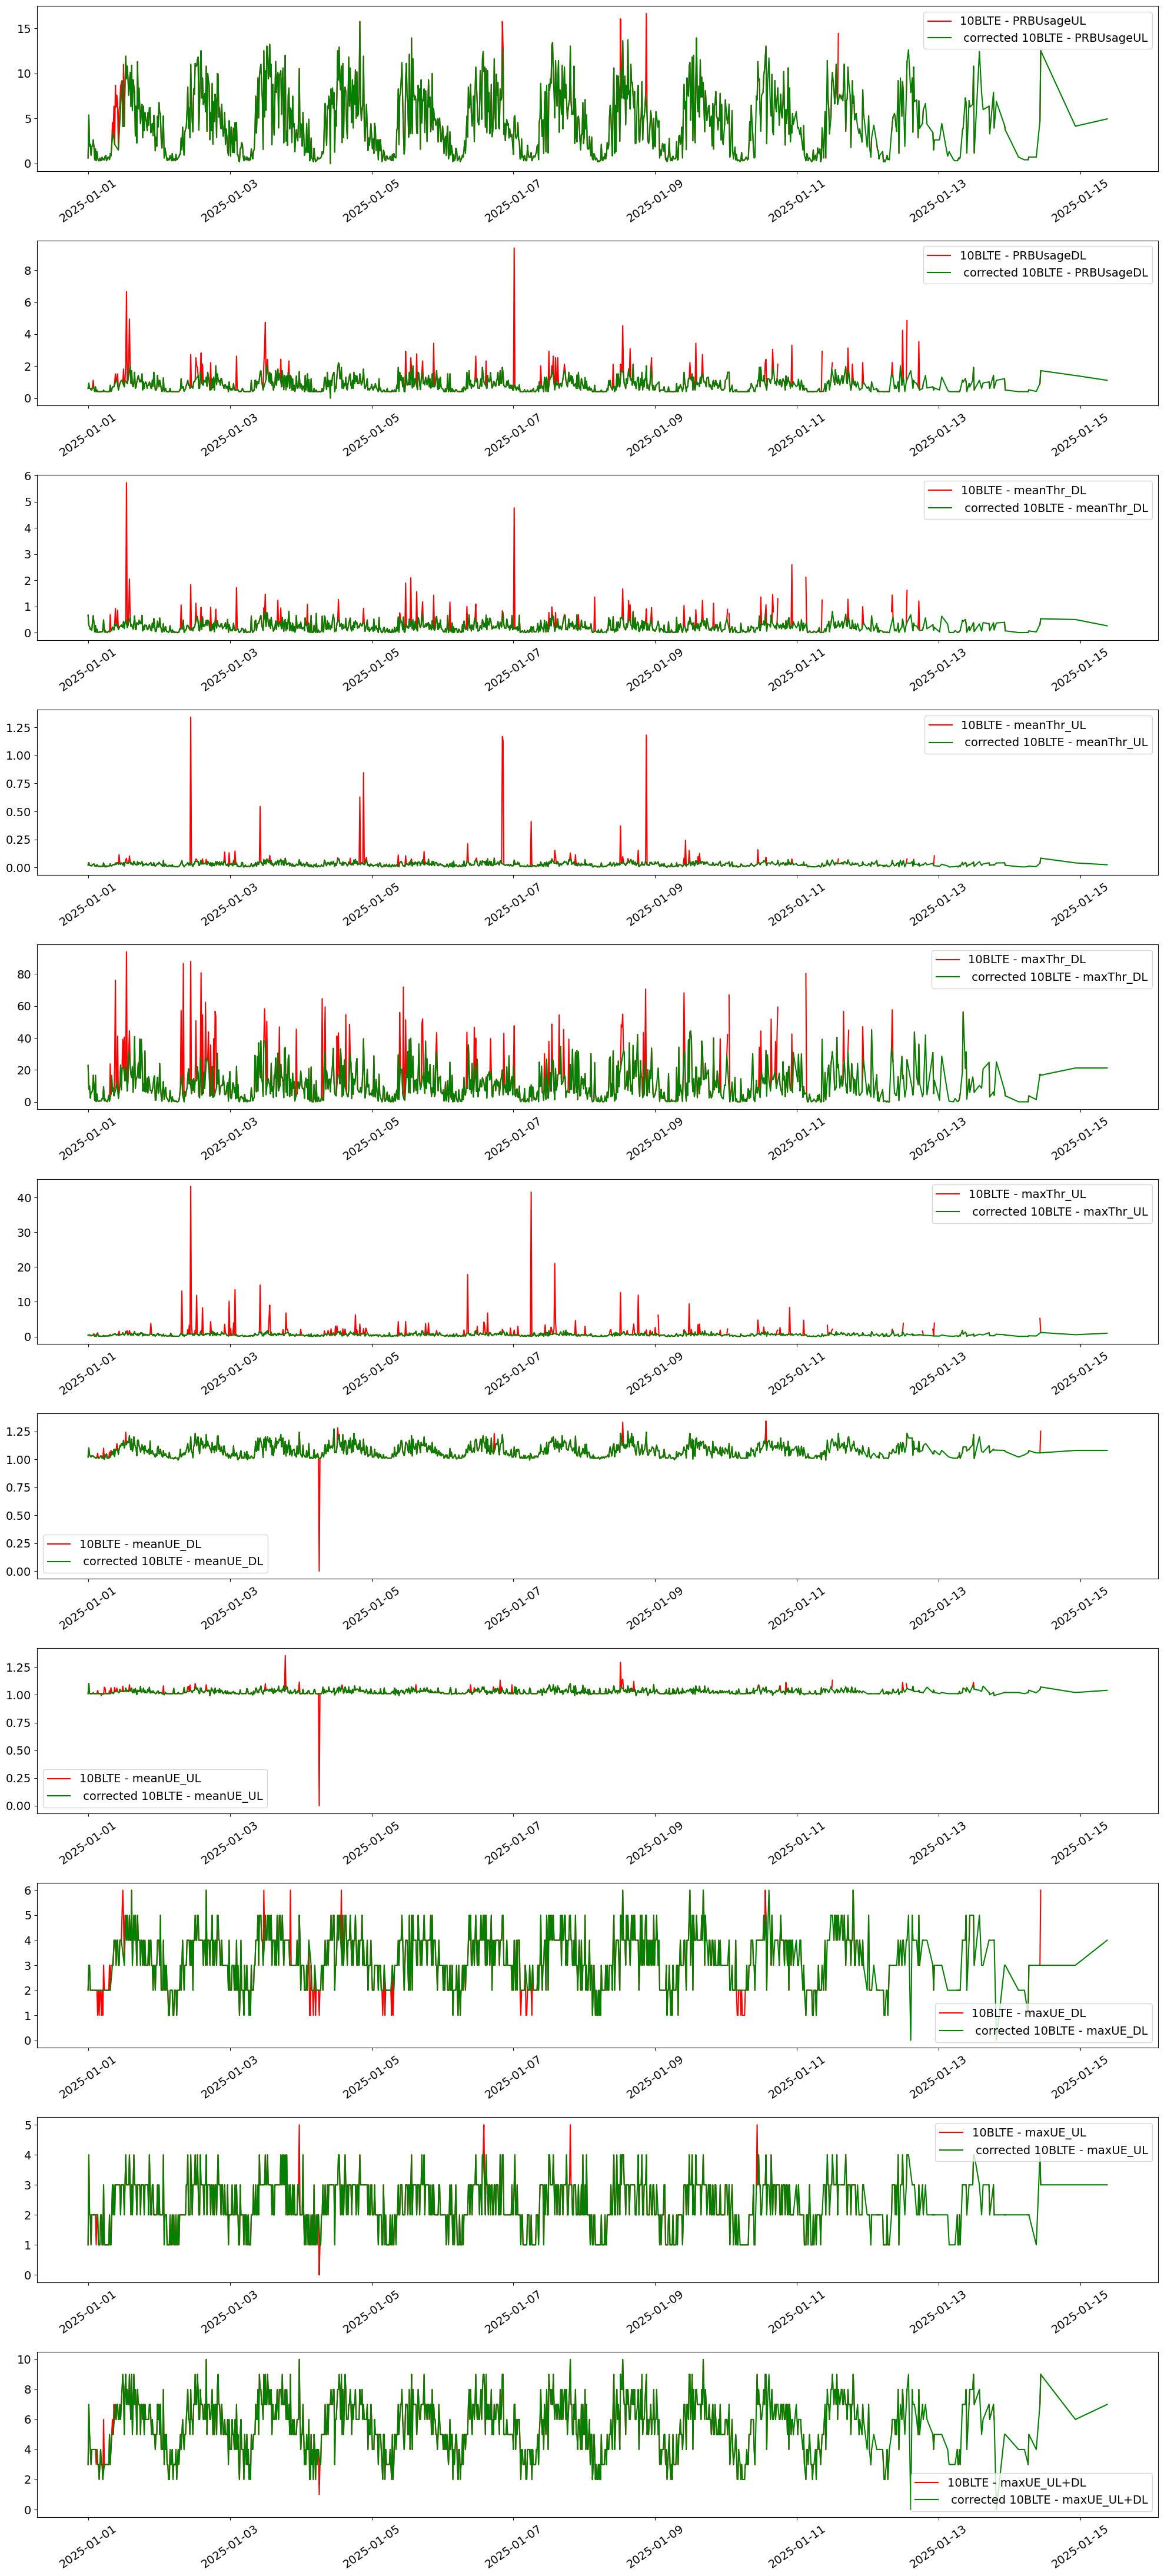

In [65]:
gps = [gp[1] for gp in df.groupby("CellName")]
df_one_cell = gps[1]
df_one_cell = add_datetime(df_one_cell)
df_one_cell_with_added_dates = replace_missing_dates(df_one_cell)


fig, axes = plt.subplots(ncols=1, nrows=len(oss_counters), figsize=(20,44))
axes= axes.flatten()
for j, oss_counter in enumerate(oss_counters):
    df_one_cell_with_added_dates_corrected = df_one_cell_with_added_dates.copy()
    df_one_cell_with_added_dates_corrected[oss_counter] = detect_replace_outliers(df_one_cell_with_added_dates_corrected,
                                                                                oss_counter,window = 96, coefficient_iqr = 1.5)

    # fill missing dates
    axes[j].plot(df_one_cell_with_added_dates.index,df_one_cell_with_added_dates[oss_counter],color="r",
            label="""{cellname} - {oss_counter}""".format(oss_counter=oss_counter,
                                                    cellname = df_one_cell["CellName"].values[0]))

    # detect outliers and fill them
    axes[j].plot(df_one_cell_with_added_dates_corrected.index,
            df_one_cell_with_added_dates_corrected[oss_counter],color="g",
        label=""" corrected {cellname} - {oss_counter}""".format(oss_counter=oss_counter,
                                                cellname = df_one_cell["CellName"].values[0]))

    axes[j].tick_params(axis='x', rotation=35)
    axes[j].legend(loc='best')


plt.tight_layout()
plt.show()

08:31:28 - cmdstanpy - INFO - Chain [1] start processing
08:31:28 - cmdstanpy - INFO - Chain [1] done processing


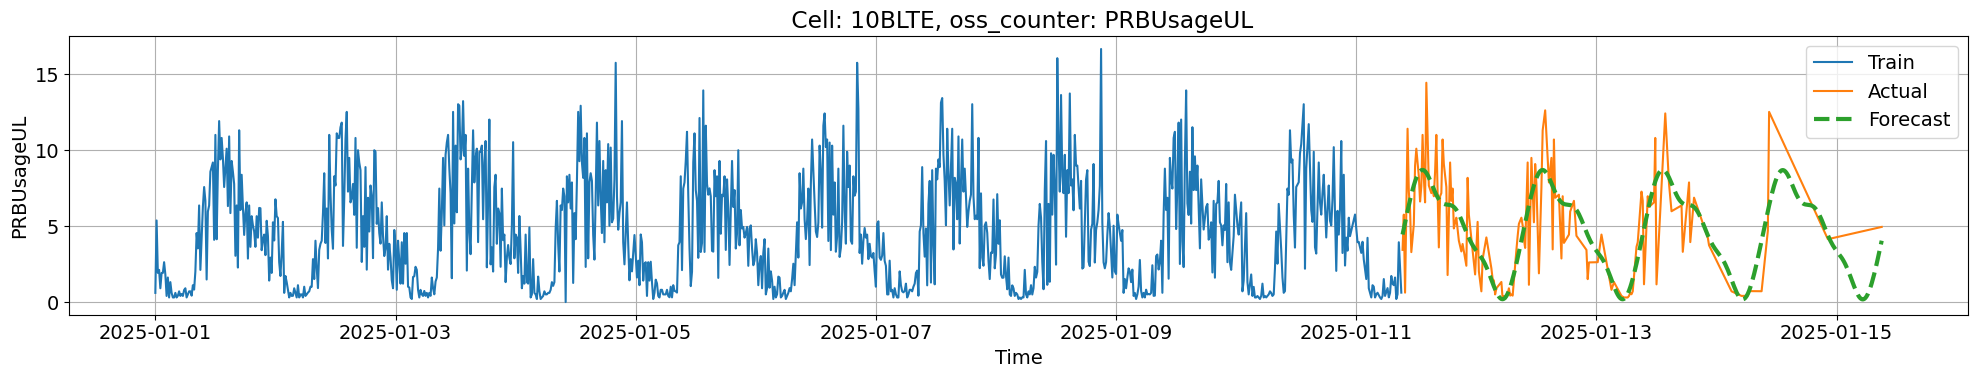

08:31:29 - cmdstanpy - INFO - Chain [1] start processing
08:31:29 - cmdstanpy - INFO - Chain [1] done processing


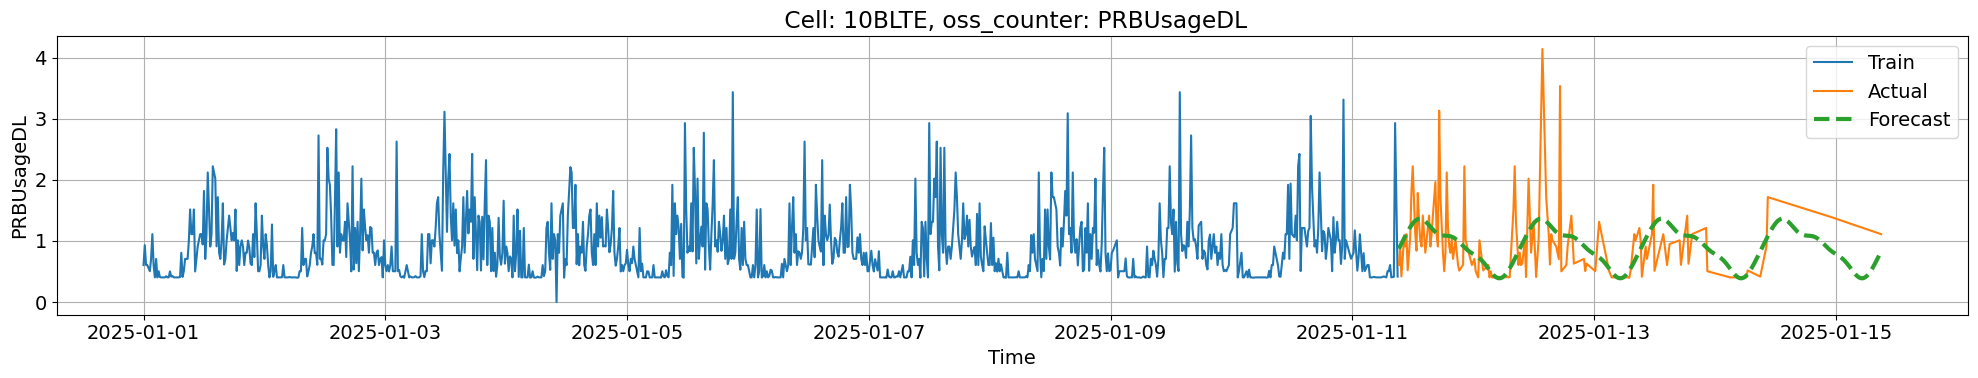

08:31:30 - cmdstanpy - INFO - Chain [1] start processing
08:31:30 - cmdstanpy - INFO - Chain [1] done processing


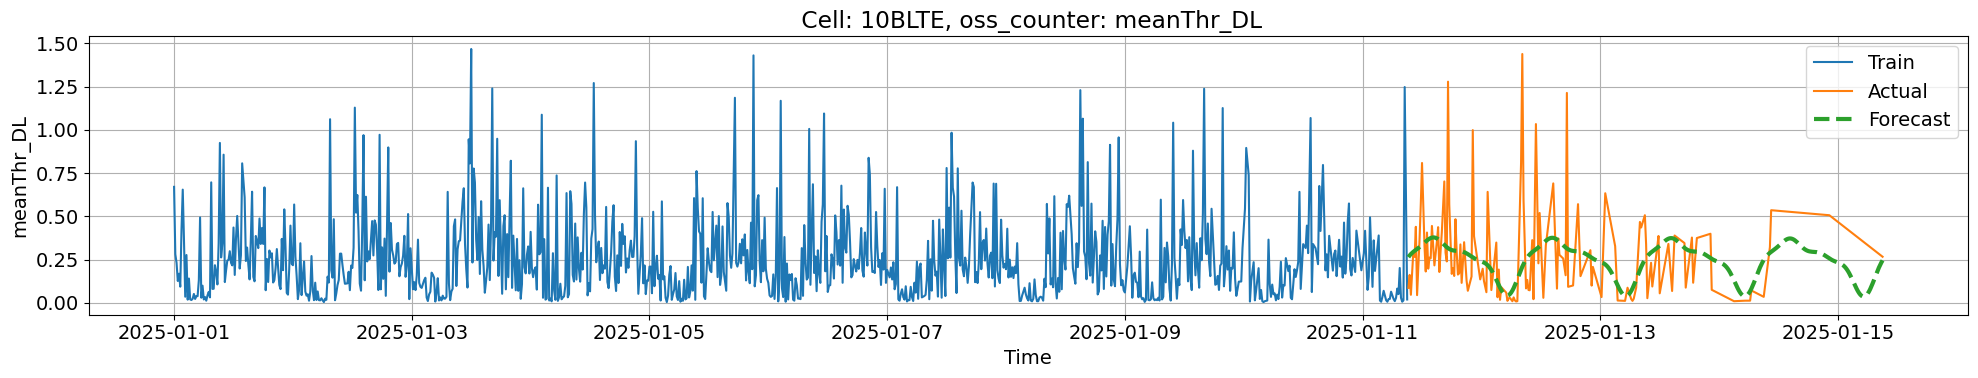

08:31:30 - cmdstanpy - INFO - Chain [1] start processing
08:31:31 - cmdstanpy - INFO - Chain [1] done processing


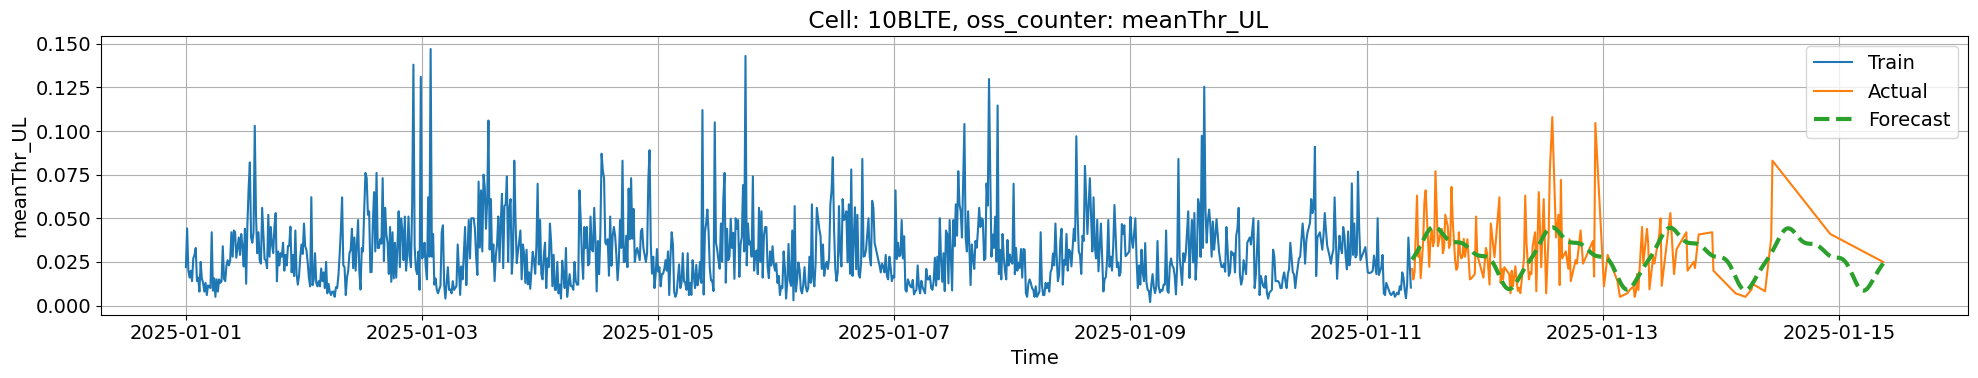

08:31:31 - cmdstanpy - INFO - Chain [1] start processing
08:31:31 - cmdstanpy - INFO - Chain [1] done processing


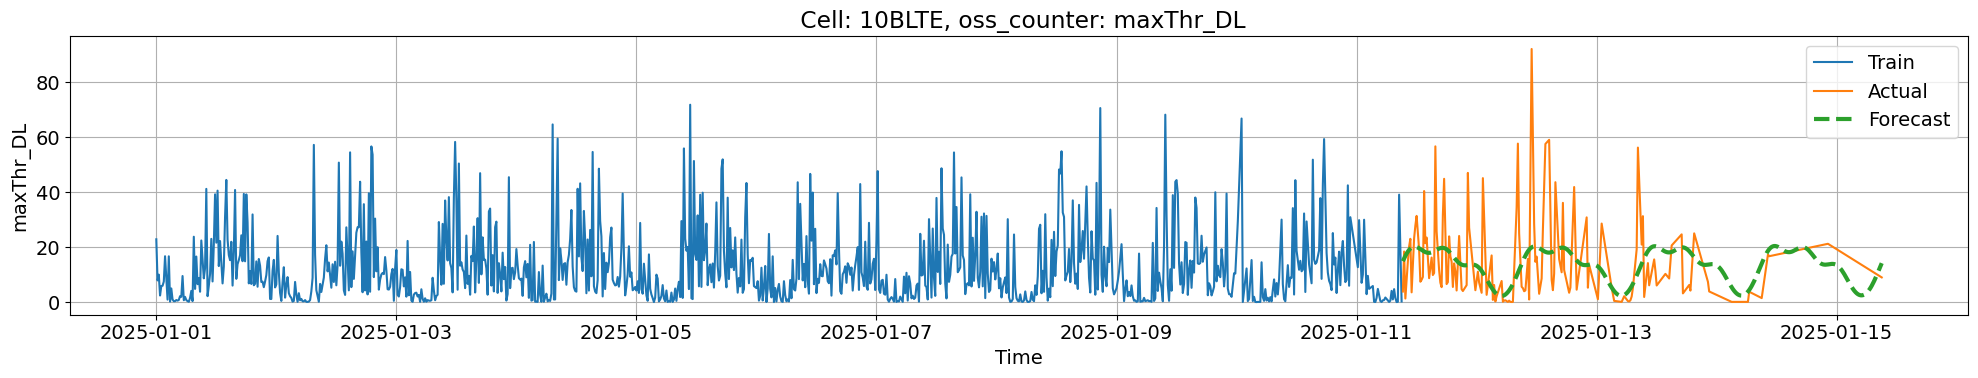

08:31:32 - cmdstanpy - INFO - Chain [1] start processing
08:31:32 - cmdstanpy - INFO - Chain [1] done processing


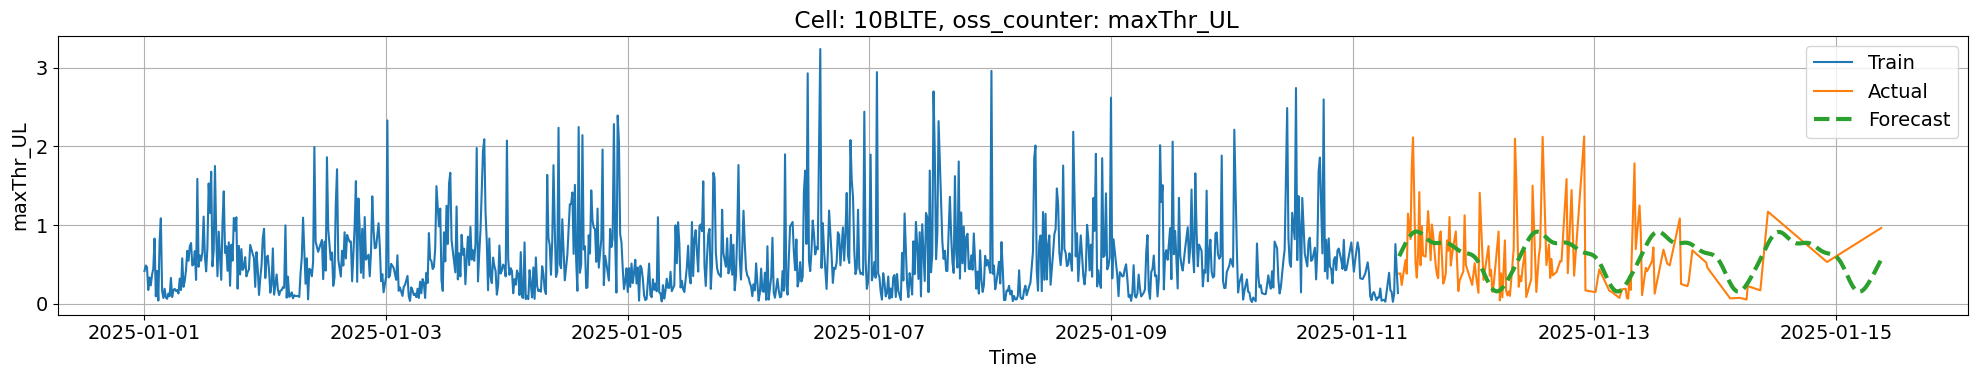

08:31:33 - cmdstanpy - INFO - Chain [1] start processing
08:31:33 - cmdstanpy - INFO - Chain [1] done processing


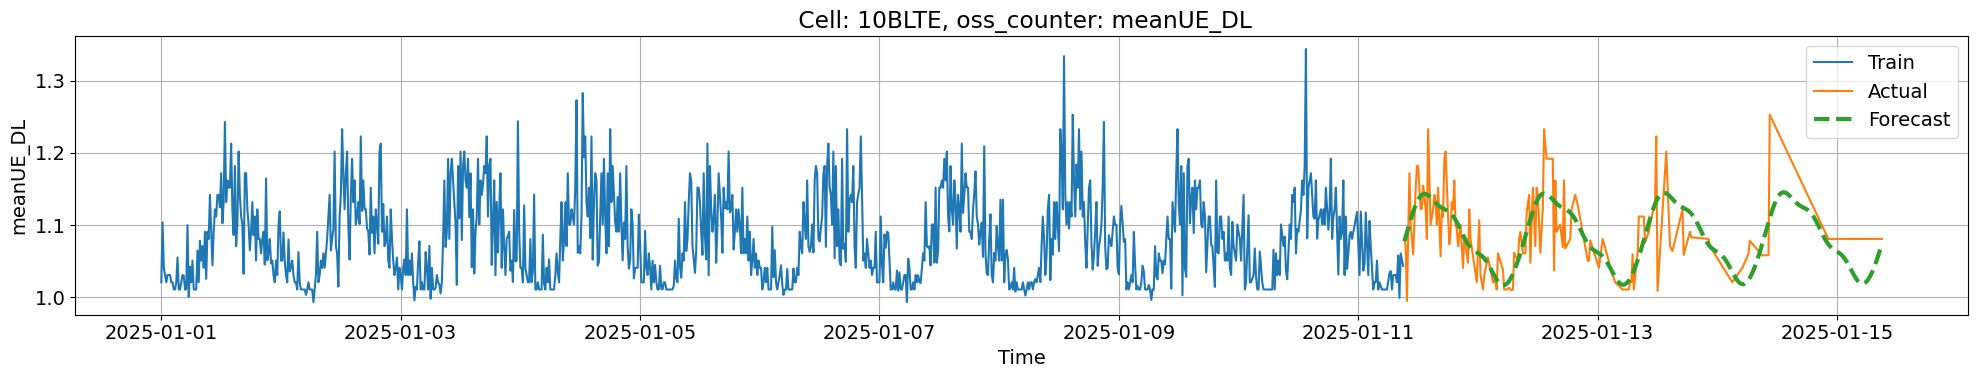

08:31:34 - cmdstanpy - INFO - Chain [1] start processing
08:31:34 - cmdstanpy - INFO - Chain [1] done processing


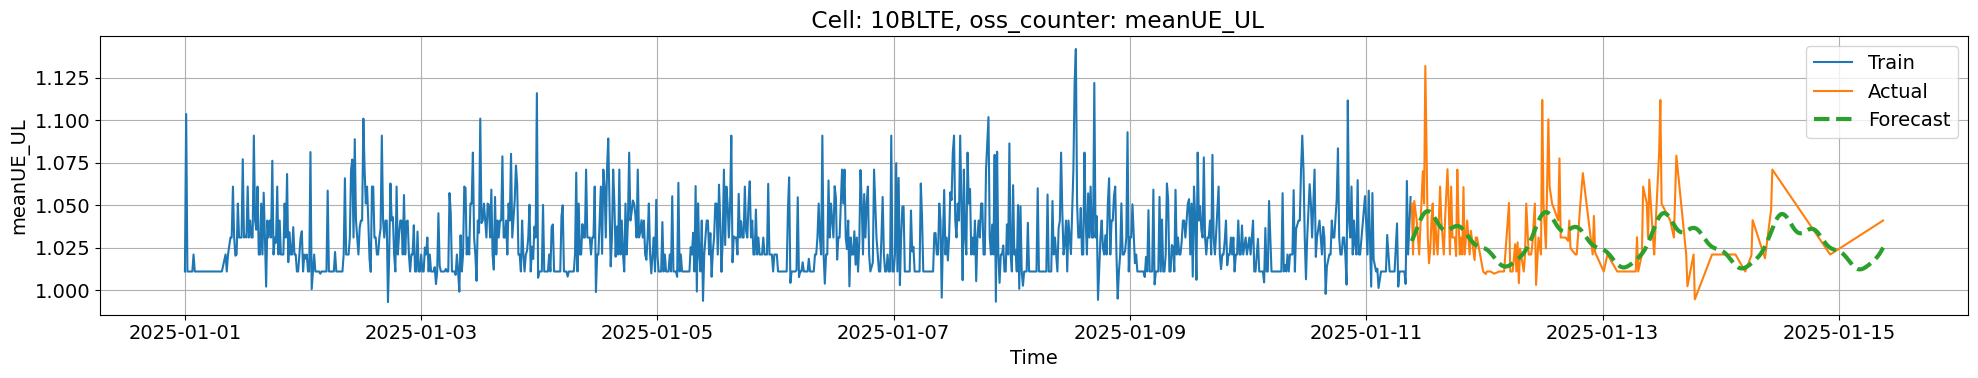

08:31:35 - cmdstanpy - INFO - Chain [1] start processing
08:31:35 - cmdstanpy - INFO - Chain [1] done processing


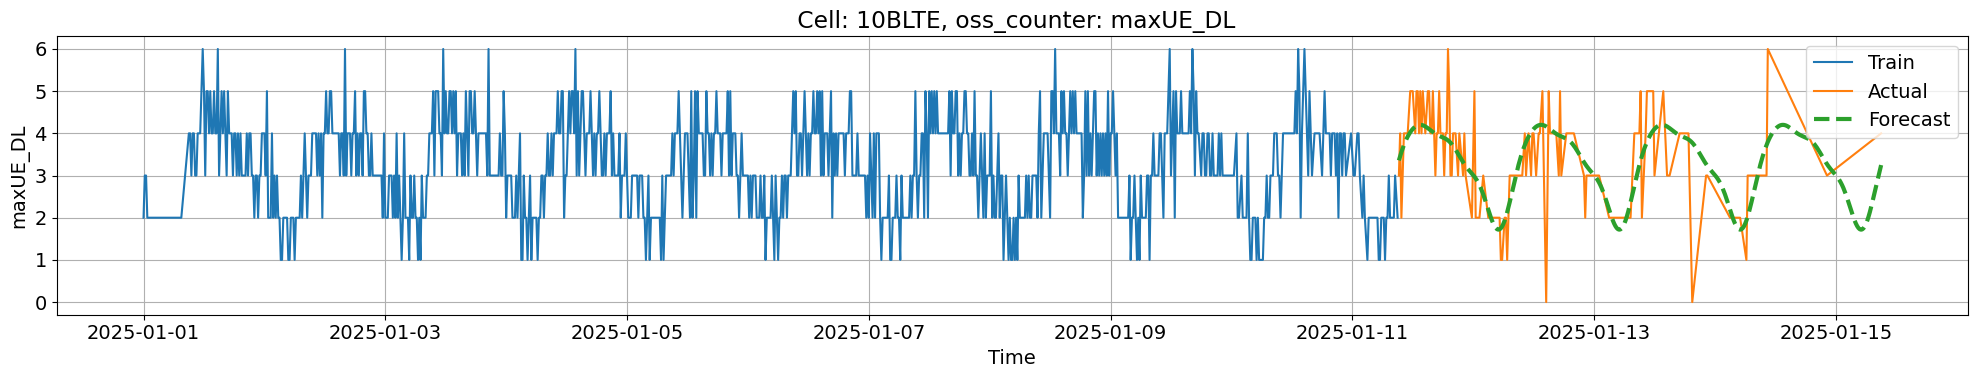

08:31:36 - cmdstanpy - INFO - Chain [1] start processing
08:31:36 - cmdstanpy - INFO - Chain [1] done processing


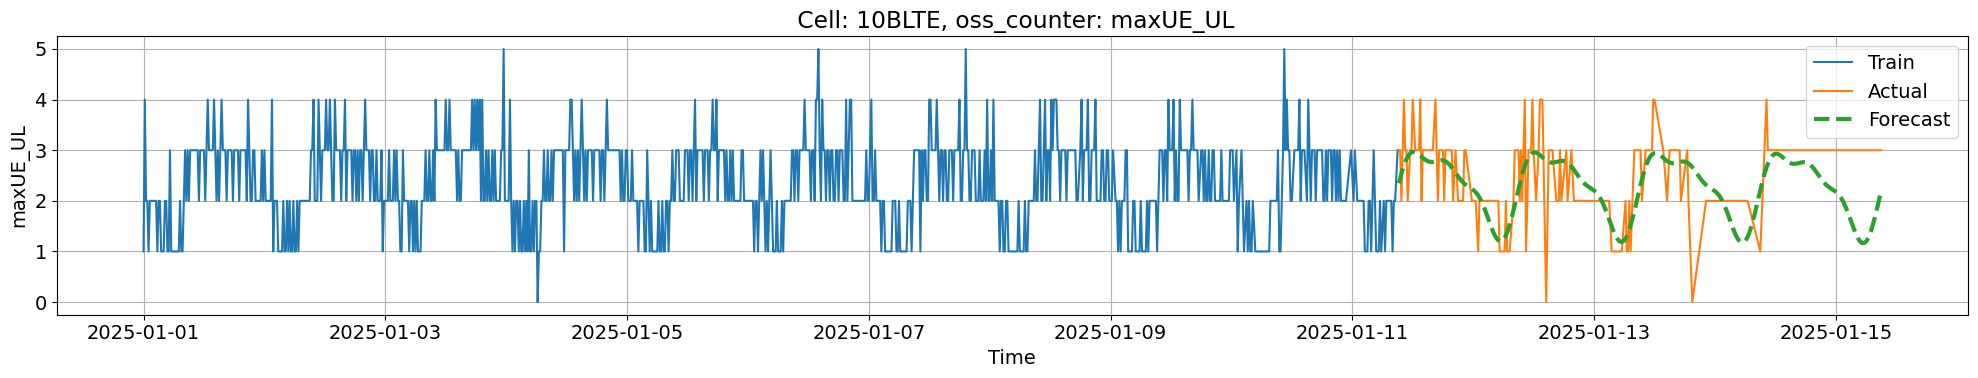

08:31:36 - cmdstanpy - INFO - Chain [1] start processing
08:31:36 - cmdstanpy - INFO - Chain [1] done processing


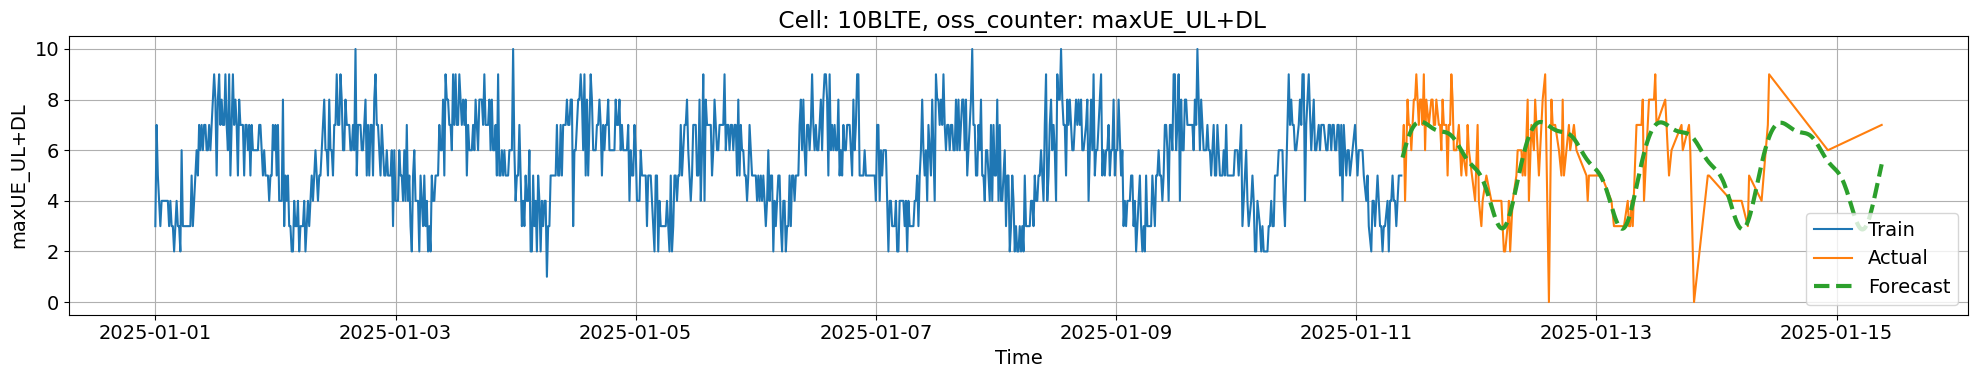

,CellName,oss_counter,MAE,RMSE,MAPE
0,10BLTE,PRBUsageUL,1.458924,1.986825,47.756939
1,10BLTE,PRBUsageDL,0.346158,0.473868,35.773709
2,10BLTE,meanThr_DL,0.156191,0.202912,138.514677
3,10BLTE,meanThr_UL,0.012731,0.016826,46.927552
4,10BLTE,maxThr_DL,7.972634,11.341233,316.319072
5,10BLTE,maxThr_UL,0.289264,0.377403,78.655680
6,10BLTE,meanUE_DL,0.028707,0.038067,2.587623
7,10BLTE,meanUE_UL,0.011902,0.016428,1.143476
8,10BLTE,maxUE_DL,0.602942,0.875944,inf
9,10BLTE,maxUE_UL,0.550501,0.737883,inf


In [66]:
df_processed = pd.concat([process_oss_counters(cell_name, df_one_cell, oss_counters)
                              for cell_name, df_one_cell in df.groupby("CellName")]).reset_index()
df_selected = df_processed[df_processed["CellName"].isin(['10BLTE'])]
df_metrics = forecast_oss_counter_per_cell(df_selected, oss_counters)
display(df_metrics)